In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import sym_metanet as metanet
from sym_metanet import (
    Destination,
    Link,
    MainstreamOrigin,
    MeteredOnRamp,
    Network,
    Node,
    engines,
)

In [2]:
#time input
start_point = 6*12
end_point = 22*12
#file input
flow = pd.read_csv("../event_model_flow.csv",index_col=0,parse_dates=True).iloc[start_point:end_point]
speed = pd.read_csv("../event_model_speed.csv",index_col=0,parse_dates=True).iloc[start_point:end_point]
off_ramp_rate = pd.read_csv("../event_model_down.csv",index_col=0,parse_dates=True).iloc[start_point:end_point]
on_ramp = pd.read_csv("../event_model_up.csv",index_col=0,parse_dates=True).iloc[start_point:end_point]
#time parameters input
measure_time = 300
simulation_time = 4
sampling_interval = int(measure_time / simulation_time)
T = simulation_time/3600
#global parameters input
tau = 18 / 3600
kappa = 40
eta = 60
delta = 0.0122
phi = 0.02
#local parameter input(以下参数均可考虑异质性)
C = 2000 #匝道通行能力
a = 1.867
rho_crit = 33.5
rho_max = 180
v_free = 102

98

In [ ]:
lanes = [4,4,4,4,4,2,2]
link_lengths = [1.15,0.30,5.41,1.24,0.68,0.2,0.2]
num_segments = [5,1,27,6,3,1,1]
segment_lengths = [round(i,3) for i in list(np.array(link_lengths)/np.array(num_segments))]
N1 = Node(name="N1")
N2 = Node(name="N2")
N3 = Node(name="N3")
N4 = Node(name="N4")
N5 = Node(name="N5")
N6 = Node(name="N6")
N_off1 = Node(name="N_off1")
N_off2 = Node(name="N_off2")


O1 = MainstreamOrigin(name="O1")
O_GL = MeteredOnRamp(C, name="O_GL")
O_JC = MeteredOnRamp(C, name="O_JC")

D1 = Destination(name="D1")
D_GL = Destination(name="D_GL")
D_JC = Destination(name="D_JC")

L1 = Link(num_segments[0], lanes[0], segment_lengths[0], rho_max, rho_crit, v_free, a, name="L1")
L2 = Link(num_segments[1], lanes[1], segment_lengths[1], rho_max, rho_crit, v_free, a, name="L2")
L3 = Link(num_segments[2], lanes[2], segment_lengths[2], rho_max, rho_crit, v_free, a, name="L3")
L4 = Link(num_segments[3], lanes[3], segment_lengths[3], rho_max, rho_crit, v_free, a, name="L4")
L5 = Link(num_segments[4], lanes[4], segment_lengths[4], rho_max, rho_crit, v_free, a, name="L5")
L_off1 = Link(1, 2, 0.2, rho_max, rho_crit, v_free, a, name="L_off1") #1段两百米的下匝道（2车道）
L_off2 = Link(1, 2, 0.2, rho_max, rho_crit, v_free, a, name="L_off2")

net = (
    Network(name="A1")
    .add_path(origin=O1, path=(N1, L1, N2, L2, N3, L3, N4, L4, N5, L5, N6), destination=D1)
    .add_path(path=(N1, L1, N2,L_off1,N_off1), destination=D_GL)
    .add_path(path=(N1, L1, N2, L2, N3, L3, N4,L_off2,N_off2), destination=D_JC)
    .add_origin(O_GL, N3)
    .add_origin(O_JC, N5)
)
engines.use("numpy")

net.is_valid(raises=True)
init_conditions = {L1:{'rho':np.array([20 for i in range(L1.N)]),'v':np.array([90 for i in range(L1.N)]),'turningrate':np.array([1])},
                   L2:{'rho':np.array([20 for i in range(L2.N)]),'v':np.array([90 for i in range(L2.N)]),'turningrate':np.array([1])},
                   L3:{'rho':np.array([20 for i in range(L3.N)]),'v':np.array([90 for i in range(L3.N)]),'turningrate':np.array([1])},
                   L4:{'rho':np.array([20 for i in range(L4.N)]),'v':np.array([90 for i in range(L4.N)]),'turningrate':np.array([1])},
                   L5:{'rho':np.array([20 for i in range(L5.N)]),'v':np.array([90 for i in range(L5.N)]),'turningrate':np.array([1])},
                   L_off1:{'rho':np.array([20 for i in range(L_off1.N)]),'v':np.array([90 for i in range(L_off1.N)]),'turningrate':np.array([1])},
                   L_off2:{'rho':np.array([20 for i in range(L_off2.N)]),'v':np.array([90 for i in range(L_off2.N)]),'turningrate':np.array([1])},
                   O1:{'w':np.array([0]),'v_ctrl':np.array([np.inf]),'d':np.array([1000])},
                   O_GL:{'w':np.array([0]),'r':np.array([1]),'d':np.array([1000])},
                   O_JC:{'w':np.array([0]),'r':np.array([1]),'d':np.array([1000])},}
main_links = [L1,L2,L3,L4,L5]
off_links = [L_off1,L_off2]
main_origin = [O1]
ramp_origin = [O_GL,O_JC]
RHO = []
V = []
TURN = []
D = []
W = []
turningrate_std = 0
demand_std = 0
def states_regulate(all_states):
    rho = all_states[0:sum(num_segments)]
    v = all_states[sum(num_segments):2*sum(num_segments)]
    turn = all_states[2*sum(num_segments):2*sum(num_segments)+len(num_segments)]
    w = all_states[2*sum(num_segments)+len(num_segments):2*sum(num_segments)+len(num_segments)+len(main_origin+ramp_origin)]
    d = all_states[2*sum(num_segments)+len(num_segments)+len(main_origin+ramp_origin):2*sum(num_segments)+len(num_segments)+2*len(main_origin+ramp_origin)]
    init_conditions = {}
    k1 = 0
    k2 = 0
    for index,link in enumerate(main_links+off_links):
        init_conditions[link] = {}
        k2 += num_segments[index]
        init_conditions[link]['rho'] = rho[k1:k2]
        init_conditions[link]['v'] = v[k1:k2]
        init_conditions[link]['turningrate'] = np.array([turn[index]]) ###需要修改
        k1 = k2
    for index,origin in enumerate(main_origin+ramp_origin):
        init_conditions[origin] = {}
        init_conditions[origin]['w'] = np.array([w[index]])
        if origin == O1:
            init_conditions[origin]['v_ctrl'] = np.array([np.inf])
        else:
            init_conditions[origin]['r'] = np.array([1])
        init_conditions[origin]['d'] = np.array([d[index]])
    return init_conditions
net.step(init_conditions=init_conditions,T=T, tau=tau, eta=eta, kappa=kappa, delta=delta)
rho = np.hstack([net.states[l]['rho'] for l in main_links+off_links])
v = np.hstack([net.states[l]['v'] for l in main_links+off_links])
turn = np.hstack([max(net.disturbances[l]['turningrate'],0) for l in main_links+off_links])
w = np.hstack([net.states[o]['w'] for o in main_origin+ramp_origin])
d = np.hstack([max(net.disturbances[o]['d'],0) for o in main_origin+ramp_origin])
all_states = np.hstack([rho,v,turn,w,d])

In [4]:
def fx(all_states,T):
    init_conditions = states_regulate(all_states)
    net.step(init_conditions=init_conditions,T=T, tau=tau, eta=eta, kappa=kappa, delta=delta)
    rho = np.hstack([net.next_states[l]['rho'] for l in main_links+off_links])
    v = np.hstack([net.next_states[l]['v'] for l in main_links+off_links])
    turn = np.hstack([max(net.disturbances[l]['turningrate']+np.random.normal(0,turningrate_std),0) for l in main_links+off_links])
    w = np.hstack([net.next_states[o]['w'] for o in main_origin+ramp_origin])
    d = np.hstack([max(net.disturbances[o]['d']+np.random.normal(0,demand_std),0) for o in main_origin+ramp_origin])
    all_states = np.hstack([rho,v,turn,w,d])
    return all_states

In [6]:
def hx(states):
    return np.array([states[0]*states[44],states[41]*states[85],states[44],states[85]])

In [ ]:
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF
sigmas = MerweScaledSigmaPoints(all_states.shape[0], alpha=.1, beta=2., kappa=1.)
ukf = UKF(dim_x=all_states.shape[0], dim_z=hx(all_states).shape[0], fx=fx,
          hx=hx, dt=T, points=sigmas)
ukf.x = all_states
ukf.P = np.diag([0.001**2]*101)
ukf.R = np.diag([0.00002**2,]*4)
ukf.Q = np.eye(101)*0.001**2

In [10]:
from tqdm import tqdm
tmp = []
for time_index in tqdm(range(50)):
    ukf.predict()
    z = [1805,1100,65,95]
    ukf.update(z)
    tmp.append(ukf.x)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:12<00:00,  3.87it/s]


In [11]:
zs = []
for i in range(50):
    zs.append(z)

In [13]:
means,covariances = ukf.batch_filter(zs)

In [14]:
means

array([[  27.88852856,   30.32979904,   29.57992094, ..., 1029.06431882,
         999.9959388 ,  997.71979613],
       [  27.88851319,   30.32968451,   29.57958772, ..., 1029.63908735,
         999.99542072,  997.67137447],
       [  27.88849159,   30.32950915,   29.57903911, ..., 1030.21944872,
         999.99487895,  997.62240183],
       ...,
       [  27.88699195,   30.3196337 ,   29.57799782, ..., 1062.08470885,
         999.93961185,  994.86313739],
       [  27.88696007,   30.3194361 ,   29.57804355, ..., 1062.91927689,
         999.93749499,  994.79076371],
       [  27.88692643,   30.31922059,   29.57802214, ..., 1063.75927281,
         999.93532809,  994.71798532]])

In [17]:
xs,ps,ks = ukf.rts_smoother(means,covariances)

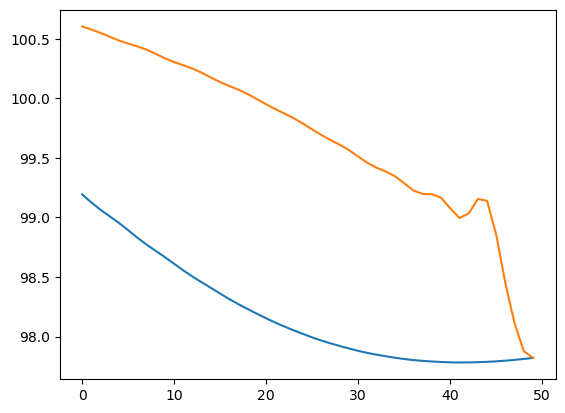

In [56]:
plt.plot(means[:,-22])
plt.plot(xs[:,-22])


In [10]:
all_states

array([1.25120773e+01, 2.00000000e+01, 2.00000000e+01, 2.00000000e+01,
       2.00000000e+01, 1.66666667e+01, 2.13888889e+01, 2.00000000e+01,
       2.00000000e+01, 2.00000000e+01, 2.00000000e+01, 2.00000000e+01,
       2.00000000e+01, 2.00000000e+01, 2.00000000e+01, 2.00000000e+01,
       2.00000000e+01, 2.00000000e+01, 2.00000000e+01, 2.00000000e+01,
       2.00000000e+01, 2.00000000e+01, 2.00000000e+01, 2.00000000e+01,
       2.00000000e+01, 2.00000000e+01, 2.00000000e+01, 2.00000000e+01,
       2.00000000e+01, 2.00000000e+01, 2.00000000e+01, 2.00000000e+01,
       2.00000000e+01, 1.51690821e+01, 2.00000000e+01, 2.00000000e+01,
       2.00000000e+01, 2.00000000e+01, 2.00000000e+01, 2.12236907e+01,
       2.00000000e+01, 2.00000000e+01, 2.00000000e+01, 2.00000000e+01,
       8.84752116e+01, 8.84752116e+01, 8.84752116e+01, 8.84752116e+01,
       8.84752116e+01, 8.84752116e+01, 8.84497950e+01, 8.84752116e+01,
       8.84752116e+01, 8.84752116e+01, 8.84752116e+01, 8.84752116e+01,
      

In [ ]:
net.next_states[L2]['rho']

In [ ]:
net.next_states[L1]['rho']

In [ ]:
import matplotlib.pyplot as plt
plt.plot(v)

In [ ]:
init_conditions